In [ ]:
!pip install scikit-multilearn
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
%matplotlib inline
import matplotlib.pyplot as plt

RANDOM_SEED = 6 

In [ ]:
data=pd.read_csv("train.csv",index_col="tripid")

features_df=data.drop('label',axis=1)
label_df=data['label'].replace(['correct','incorrect'],[1,0])

In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a)) 
  r = 6371 
  return c * r

def update_features(features_df):

    distances_km = []
    second_per_fare = []
    fare_per_distance = []
    fare_per_second = []
    waitingFare_per_second = []

    for row in features_df.itertuples(index=True):
      distances_km.append(
          haversine(row.drop_lon, row.drop_lat, row.pick_lon, row.pick_lat)
      )

    features_df['distance'] = distances_km

    for row in features_df.itertuples(index=True):
      if row.fare == 0:
        second_per_fare.append(np.nan)
      else:
        second_per_fare.append(row.duration/row.fare)

      if row.distance == 0:
        fare_per_distance.append(np.nan)
      else:
        fare_per_distance.append(row.fare/row.distance)

      if row.duration == 0:
        fare_per_second.append(np.nan)
      else:
        fare_per_second.append(row.fare/row.duration)

      if row.meter_waiting == 0:
        waitingFare_per_second.append(np.nan)
      else:
        waitingFare_per_second.append(row.meter_waiting_fare/(row.meter_waiting))

    features_df['fare_per_distance'] = fare_per_distance
    features_df['fare_per_second'] = fare_per_second
    features_df['second_per_fare'] = second_per_fare
    features_df['waitingFare_per_second'] = waitingFare_per_second

    features_df['total_waiting'] = features_df['meter_waiting'] + features_df['meter_waiting_till_pickup']

    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'], format='%m/%d/%Y %H:%M')
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'], format='%m/%d/%Y %H:%M')

    features_df['pickup_time_minutes'] = features_df['pickup_time'].dt.minute
    features_df['pickup_time_hours'] = features_df['pickup_time'].dt.hour
    features_df['pickup_time_day'] = features_df['pickup_time'].dt.day
    features_df['pickup_time_month'] = features_df['pickup_time'].dt.month

    features_df['drop_time_minutes'] = features_df['drop_time'].dt.minute
    features_df['drop_time_hours'] = features_df['drop_time'].dt.hour
    features_df['drop_time_day'] = features_df['drop_time'].dt.day
    features_df['drop_time_month'] = features_df['drop_time'].dt.month
  
    features_df=features_df.drop(['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon','drop_time','pickup_time'], axis=1)

    return features_df

In [ ]:
features_df = update_features(features_df)

In [ ]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values

In [ ]:
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder='drop'
)

features_df = preprocessor.fit_transform(features_df)

In [ ]:
from xgboost import XGBClassifier

xgb4 = XGBClassifier(learning_rate =0.1, n_estimators=490, max_depth=9,
 min_child_weight=2, gamma=0.2, subsample=0.6, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, reg_lambda = 10)


In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

In [ ]:
xgb4.fit(X_train, y_train)
None

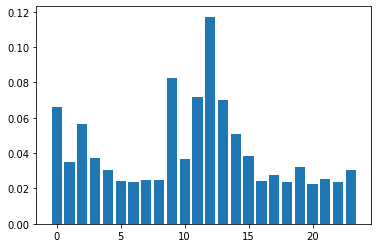

In [ ]:
#print(xgb4.feature_importances_)
from matplotlib import pyplot
pyplot.bar(range(len(xgb4.feature_importances_)), xgb4.feature_importances_)
pyplot.show()

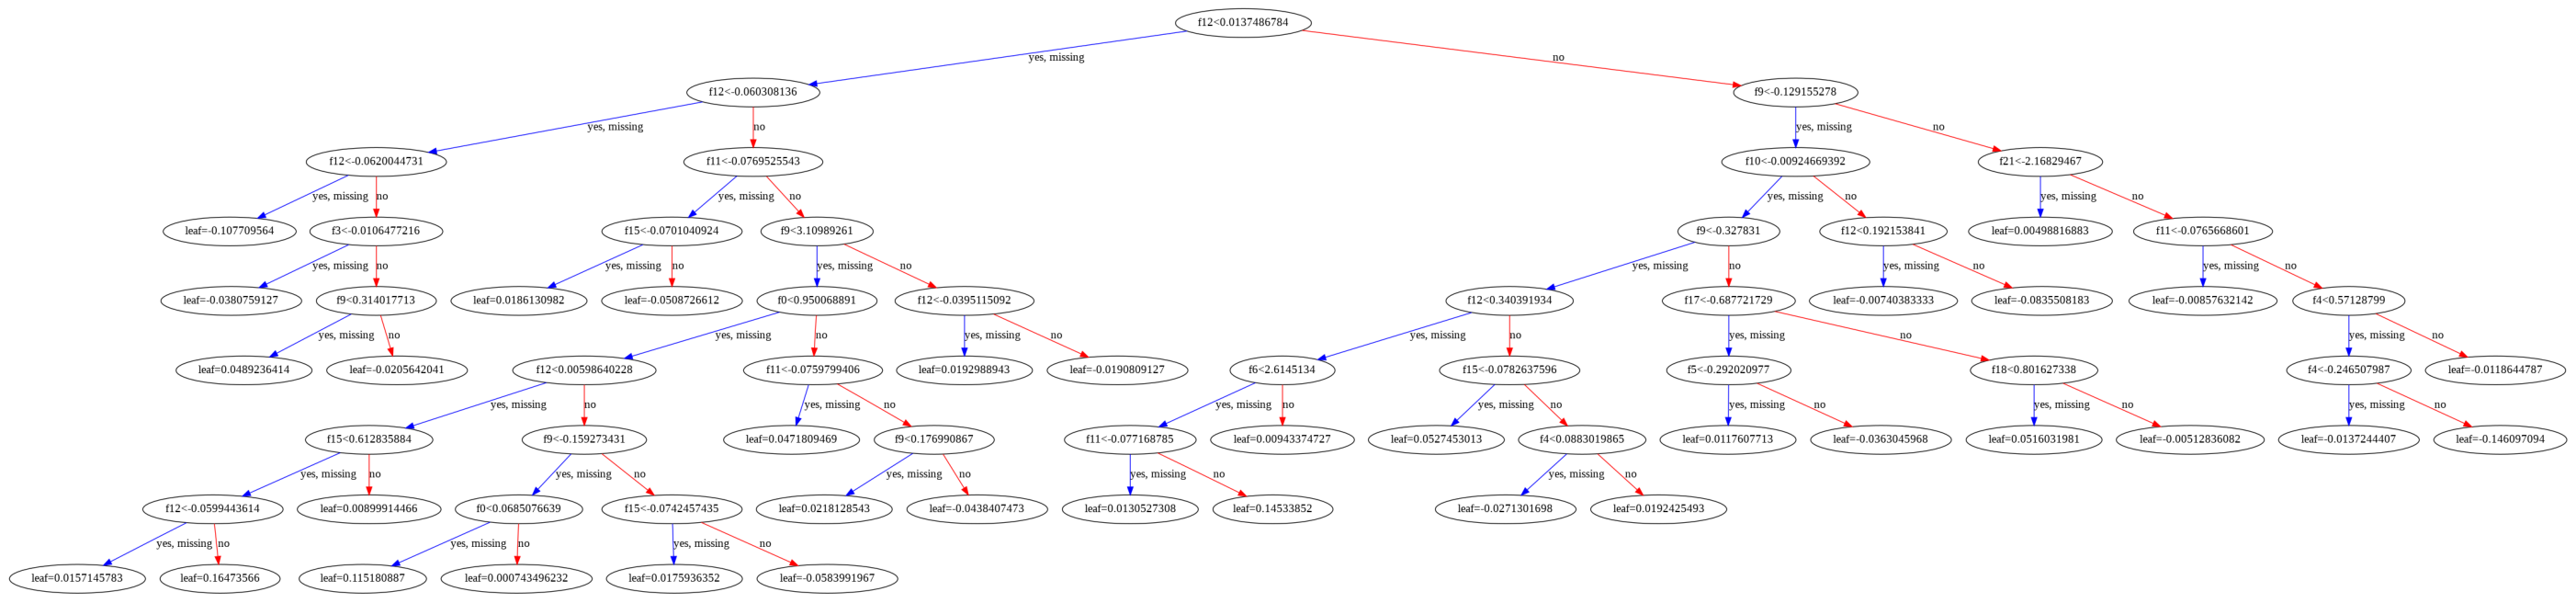

In [ ]:
from matplotlib.pylab import rcParams
from xgboost import plot_tree
##set up the parameters
rcParams['figure.figsize'] = 50,50

plot_tree(xgb4, num_trees=1)
plt.show()

In [ ]:
preds = xgb4.predict(X_eval)
preds

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
y_preds = pd.DataFrame(
    {
        "label": preds
    },
    index = y_eval.index
)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_eval, y_preds, average='macro')
#0.8638712209063968
#0.8640519194705552

0.8556464220574651

In [ ]:
#0.8488065898274382
#0.8494280999581812 - scale pos weight

#0.8269493527234628 - xgb4, distance, mhd, spendTime**2 , SMOTE -0.88323

#0.8437507326002669 - with test_size=0.2 - 0.97797

#0.8560726454619751 - xgb4, distance, mhd, spendTime**2, fare_per_distance, fare_per_second - 0.97839
#0.8621837506029646 - delete preprocessing, ... - 0.97886

#0.8585749134173074 - xgb4, distance, mhd, spendTime**2, fare_per_distance with 0, fare_per_second with 0 - 0.97824
#0.8559132052125735 - xgb4, distance, mhd, fare_per_distance, fare_per_second, second_per_fare - 0.97808

*   0.7988444121742916 - xgb4
*   0.8329000752649618 - xgb4, distance -  0.97750
*   0.8354839227541376 - xgb4, distance, mhd - 0.97781
*   0.8362269008168663 - xgb4, distance, mhd, spendTime**2 - 0.97797
*   0.8366507034438244 - xgb4, distance, mhd, spendTime**2, mean of meter_waiting_till_pickup - 0.97796
*   
*   0.8379268807855409 - xgb4, distance, minute, sin cos h, sin cos d, spend time**2 - 0.97735

*   0.7182616832275236 - xgb4, n = 200

*   0.8362289155183336 - model , n=4000 - 0.97672

In [ ]:
xgb4.fit(features_df, label_df)
None

In [ ]:
test_features_df = pd.read_csv("test.csv", 
                               index_col="tripid")

test_features_df = update_features(test_features_df)

test_features_df = preprocessor.fit_transform(test_features_df)

In [ ]:
submission_df = pd.read_csv("sample_submission.csv", 
                            index_col="tripid")

In [ ]:
test_probas = xgb4.predict(test_features_df)
test_probas

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
submission_df["prediction"] = test_probas

In [ ]:
submission_df.to_csv('my_submission.csv', index=True)

In [ ]:
!head my_submission.csv

tripid,prediction
213284604,1
213286352,0
213293973,0
213294622,1
213298687,0
213299545,0
213302332,0
213302671,0
213305594,0
